##  Batch Normalization

- Normalizes the hidden states to be gaussian (especially at initialization) and then scaling the components by a batch gain and shifting them by a bias
- because if they are way too small in values, the activation function does not activate. 
- and if they are too large, the activation function becomes saturated.

### Data

In [1]:
import torch
import torch.nn.functional as Func
import matplotlib.pyplot as plt  # for making figures
import random
import math

%matplotlib inline

In [2]:
# Black code formatter (Optional)
%load_ext lab_black

In [3]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


#### Creating the data set for the model

In [6]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    """
    This builds the dataset and split it into the appropriate sets

    Args:
        - Words: A file containing all the names

    Returns:
        - X: A tensor containing the previous sequence of characters
        - Y: A tensor containing the next character
    """
    X, Y = [], []
    for w in words:
        # print(w)

        context = [0] * block_size

        for ch in w + ".":
            ix = stoi[ch]
            X.append(
                context
            )  # append a list of block size 3 for the number of chars in a word
            Y.append(ix)  # append the character number
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
# Sampling from the dataset
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Modelling

In [8]:
class Linear:
    """Similar implementation of a linear layer in pytorch"""

    def __init__(self, feat_in, feat_out, bias=True):
        self.weight = torch.randn((feat_in, feat_out), generator=gen) / math.sqrt(
            feat_in
        )
        self.bias = torch.randn(feat_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [9]:
class BatchNorm1D:
    """Similar implementation of BatchNorm1D in pytorch"""

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Batch norm Parameters trained with backpropagation
        self.gamma = torch.ones(dim)  # gain
        self.beta = torch.zeros(dim)  # bias

        # Batch norm buffers trained with a running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var

        x_hat = (x - x_mean) / torch.sqrt(
            x_var + self.eps
        )  # normalize to unit variance

        self.out = (self.gamma * x_hat) + self.beta

        # Updating the buffers for evaluation
        if self.training:
            with torch.no_grad():
                self.running_mean = ((1 - self.momentum) * self.running_mean) + (
                    self.momentum * x_mean
                )
                self.running_var = ((1 - self.momentum) * self.running_var) + (
                    self.momentum * x_var
                )

        return self.out

    def parameters(self):
        # returning only the parameters to be used for backpropagation
        return [self.gamma, self.beta]

In [10]:
class Tanh:
    """Activation function implementation"""

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [71]:
# Initialization
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP

gen = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=gen)

layers = [
    Linear(n_embd * block_size, n_hidden),
    BatchNorm1D(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1D(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1D(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1D(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1D(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
    BatchNorm1D(vocab_size),
]

with torch.no_grad():
    # Making the last layer less confident
    layers[-1].gamma *= 0.1

    # Applying gain to the other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [72]:
# Hyper parameter optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # Constructing the Minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=gen)
    X_batch, Y_batch = X_train[ix], Y_train[ix]  # batch X,Y

    # Forward pass
    emb = C[X_batch]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors

    ## Linear layer
    for layer in layers:
        x = layer(x)

    ## Non-linearity
    loss = Func.cross_entropy(x, Y_batch)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    with torch.no_grad():
        # keeping track of the update (lr*p.grad) to data ratio
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )

    if i >= 1000:
        break

      0/ 200000: 3.2870


#### Histograms

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'Activation distribution')

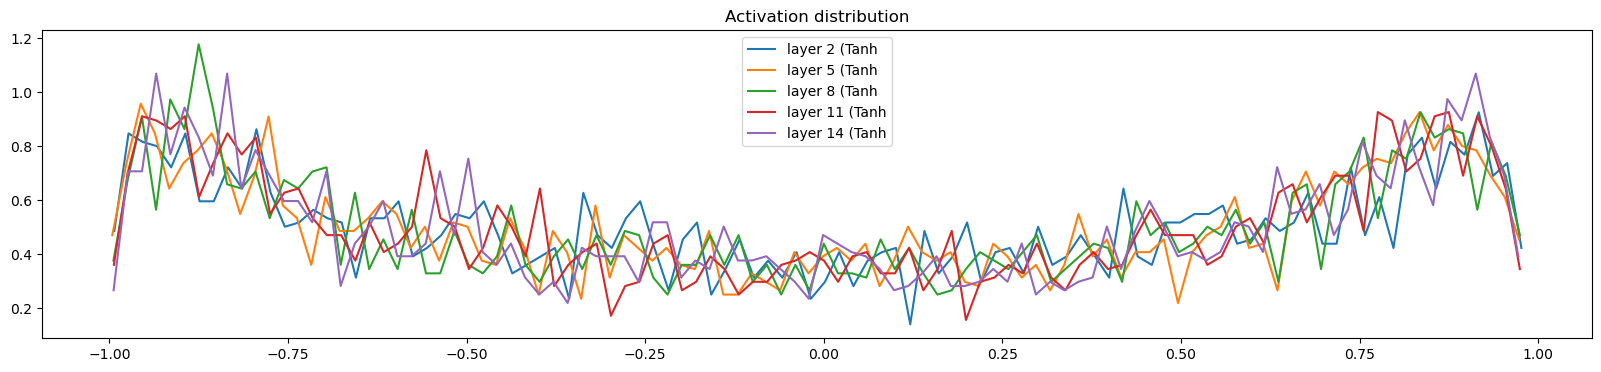

In [73]:
# Activation distribution
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("Activation distribution")

layer 2 (      Tanh): mean -0.000000, std 3.682947e-03
layer 5 (      Tanh): mean +0.000000, std 3.262604e-03
layer 8 (      Tanh): mean -0.000000, std 2.973726e-03
layer 11 (      Tanh): mean +0.000000, std 2.741104e-03
layer 14 (      Tanh): mean -0.000000, std 2.584291e-03


Text(0.5, 1.0, 'Gradient distribution')

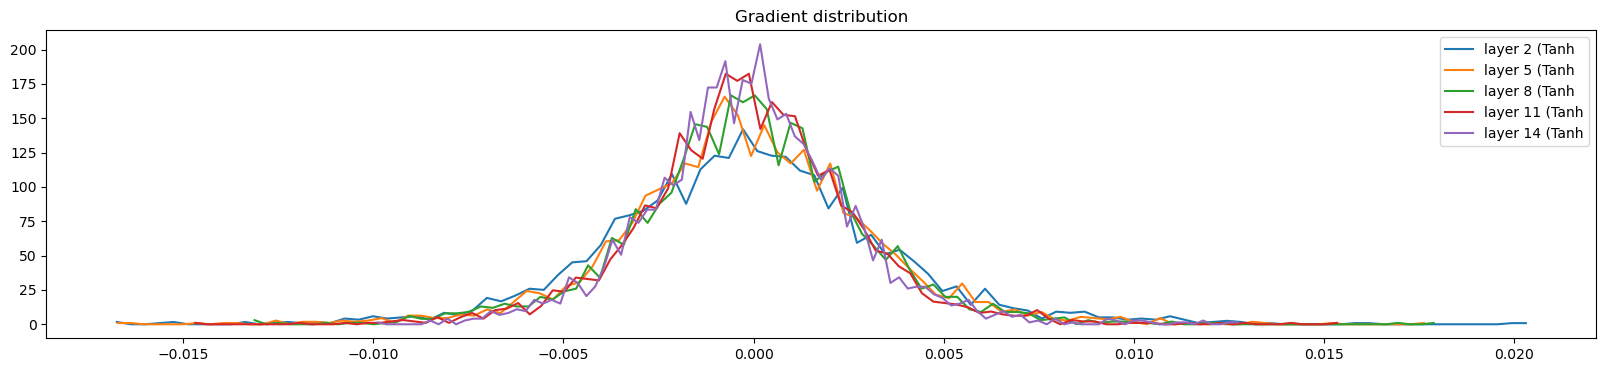

In [74]:
# Gradient Distributions
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            "layer %d (%10s): mean %+f, std %e"
            % (i, layer.__class__.__name__, t.mean(), t.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("Gradient distribution")

weight   (27, 10) | mean -0.000000 | std 1.019882e-02 | grad:data ratio 1.018843e-02
weight  (30, 100) | mean +0.000092 | std 8.238415e-03 | grad:data ratio 2.635834e-02
weight (100, 100) | mean +0.000031 | std 7.318094e-03 | grad:data ratio 4.377133e-02
weight (100, 100) | mean -0.000019 | std 6.662014e-03 | grad:data ratio 3.949890e-02
weight (100, 100) | mean -0.000019 | std 5.821506e-03 | grad:data ratio 3.468155e-02
weight (100, 100) | mean +0.000053 | std 5.445286e-03 | grad:data ratio 3.243361e-02
weight  (100, 27) | mean -0.000165 | std 1.046843e-02 | grad:data ratio 6.281253e-02


Text(0.5, 1.0, 'Weights gradient distribution')

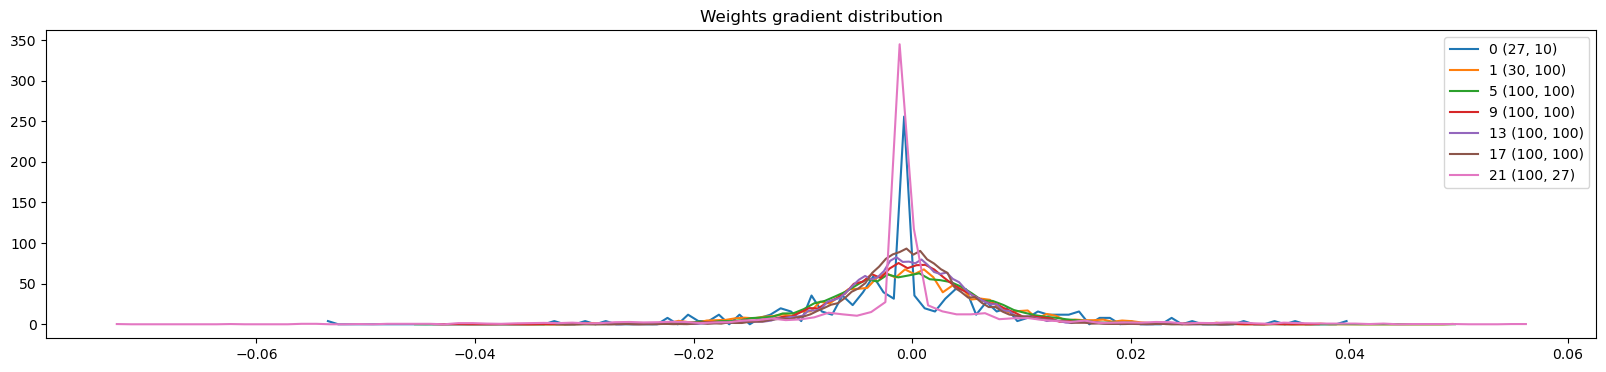

In [75]:
# Weights gradient distibution
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            "weight %10s | mean %+f | std %e | grad:data ratio %e"
            % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("Weights gradient distribution")

Text(0.5, 1.0, 'Updates to data ratios')

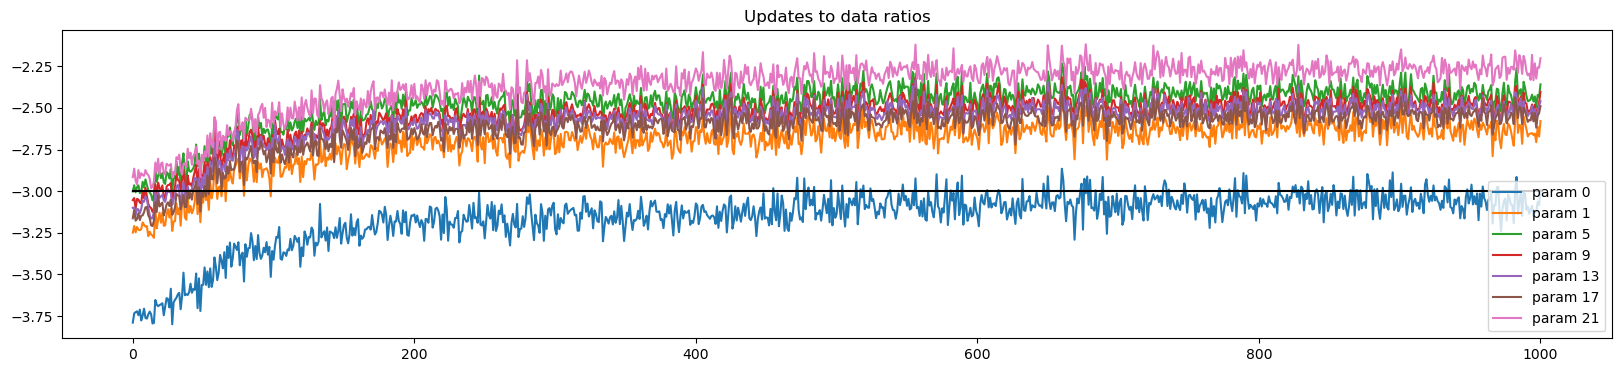

In [76]:
# Update ratios
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title("Updates to data ratios")

- Below -3.0 means the parameters are not training fast enough

In [77]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    """
    Evaluation of the arbitrary data splits

    Args:
        split (str): the name of the split to the evaluated

    Returns:
        Name and Loss of the split
    """
    x, y = {
        "train": (X_train, Y_train),
        "val": (X_dev, Y_dev),
        "test": (X_test, Y_test),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = Func.cross_entropy(x, y)
    print(split, loss.item())


# put layers into eval mode
for layer in layers:
    layer.training = False

In [78]:
split_loss("train")
split_loss("val")

train 2.434417963027954
val 2.4324371814727783


In [79]:
# Sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        x = emb.view(emb.shape[0], -1)  # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = Func.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

carpah.
qarlileif.
jmrri.
thty.
sacansa.
jazhntefapliah.
jagqeiu.
ramara.
chriiv.
kalein.
dhlm.
join.
qhijthn.
lilea.
jadbq.
wane.
ogdearyxi.
jaheininsan.
ed.
ecoia.
